In [1]:
# load modules
## Data processing and DA modules
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
## Dealing with big data and netcdf
import xarray as xr
from netCDF4 import Dataset
## ROMS packages
from xgcm import Grid
## color maps
import cmaps
import cmocean
## mapping packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
## System tools and python configuration
import os
import glob
import pandas as pd
from shapely import Polygon
import math

In [2]:
ds=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn.nc")
ds

<xarray.Dataset>
Dimensions:          (ocean_time: 73, bnds: 2, s_rho: 31, s_w: 32, tracer: 2,
                      boundary: 4, Nuser: 1, eta_rho: 600, xi_rho: 800,
                      eta_u: 600, xi_u: 799, eta_v: 599, xi_v: 800,
                      eta_psi: 599, xi_psi: 799)
Coordinates:
  * ocean_time       (ocean_time) datetime64[ns] 2025-12-30 ... 2026-12-25
  * s_rho            (s_rho) float64 -0.9839 -0.9516 ... -0.04839 -0.01613
  * s_w              (s_w) float64 -1.0 -0.9677 -0.9355 ... -0.03226 0.0
Dimensions without coordinates: bnds, tracer, boundary, Nuser, eta_rho, xi_rho,
                                eta_u, xi_u, eta_v, xi_v, eta_psi, xi_psi
Data variables: (12/51)
    ocean_time_bnds  (ocean_time, bnds) datetime64[ns] ...
    nl_tnu2          (tracer) float64 ...
    LtracerSponge    (tracer) int32 ...
    Akt_bak          (tracer) float64 ...
    Tnudg            (tracer) float64 ...
    FSobc_in         (boundary) float64 ...
    ...               ...
    lat_u            (eta_u, xi_u) float64 ...
    lat_v            (eta_v, xi_v) float64 ...
    lon_psi          (eta_psi, xi_psi) float64 ...
    lon_rho          (eta_rho, xi_rho) float64 ...
    lon_u            (eta_u, xi_u) float64 ...
    lon_v            (eta_v, xi_v) float64 ...
Attributes: (12/38)
    CDI:                        Climate Data Interface version 2.0.4 (https:/...
    Conventions:                CF-1.4, SGRID-0.3
    file:                       roms_his_0020.nc
    format:                     netCDF-3 64bit offset file
    type:                       ROMS grid file
    title:                      South-east Queensland, 1/100 (900m) degree re...
    ...                         ...
    history:                    Mon Feb 19 09:22:01 2024: ncks -A ROMS_grid_c...
    ana_file:                   ROMS/Functionals/ana_btflux.h
    CPP_options:                SEQLD, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE,...
    CDO:                        Climate Data Operators version 2.0.4 (https:/...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...
    history_of_appended_files:  Mon Feb 19 09:22:01 2024: Appended file ROMS_...

In [3]:
ds['hc']=20
def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])



    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
    z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
    z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds["z_rho0"] = ds.z_rho0.fillna(0)

        # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

In [4]:
ds = processROMSGrid(ds)

In [5]:
ds=ds.set_coords(("lon_rho","lat_rho"))

In [6]:
ds_grid=xr.open_dataset("/seq001/data/roms_his_DailyNudge_2018_5daymn_grid_vars.nc")
def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    },
    periodic=False)
    
    return gridOut
grid = makeROMSGridObject(ds_grid)
del(ds_grid)

In [7]:
omega = 7.29e-5
f = 2 * omega * np.sin(np.deg2rad(ds.lat_rho))
rho0 = 1030
ds['U_ek'] = grid.interp(ds.sustr,'X',boundary='fill') / (rho0 * f)
ds['V_ek'] = -grid.interp(ds.svstr,'Y',boundary='fill') / (rho0 * f)

In [8]:
# now calculate vertical velocities
ds['W_ek'] = grid.interp(grid.diff(ds.U_ek,'X',boundary='fill'),'X',boundary='fill') + grid.interp(grid.diff(ds.V_ek,'Y',boundary='fill'),'Y',boundary='fill')


Text(0.5, 1.0, '')

<Figure size 640x480 with 0 Axes>

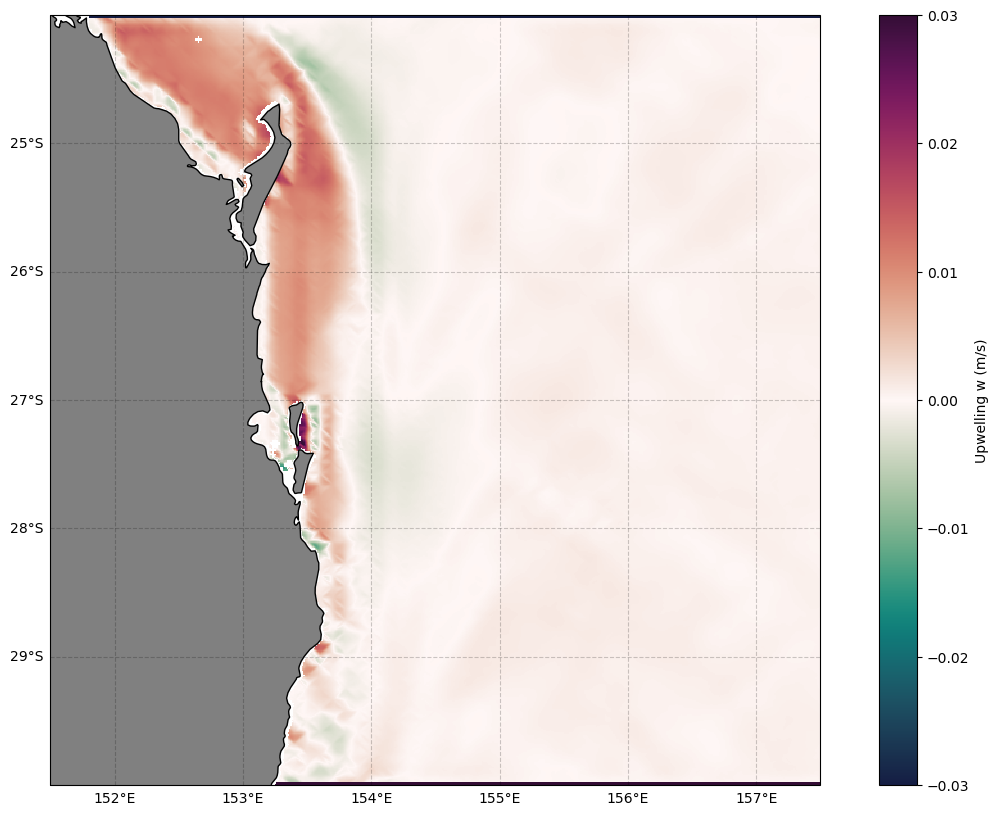

In [8]:
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([151.5, 157.5, -30, -24])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
# im = (((ds.W_ek**2).mean(dim='ocean_time'))**0.5).plot(x='lon_rho',y='lat_rho',cmap='cmo.curl', add_colorbar=False,vmin=-.1,vmax=0.1)     
#im = (((ds.W_ek**1).mean(dim='ocean_time'))**1).plot(x='lon_rho',y='lat_rho',cmap='cmo.curl', add_colorbar=False,vmin=-.03,vmax=0.03)     
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho, (((ds.W_ek**1).mean(dim='ocean_time'))**1),vmin=-.03,vmax=0.03,cmap='cmo.curl')
#co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.25)     
#ax.clabel(co, co.levels, inline=True, fontsize=10)


gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False

cbar = fig.colorbar(im) 
cbar.set_label('Upwelling w (m/s)')
ax.set_title('')  


As a Driver

IndexError: list index out of range

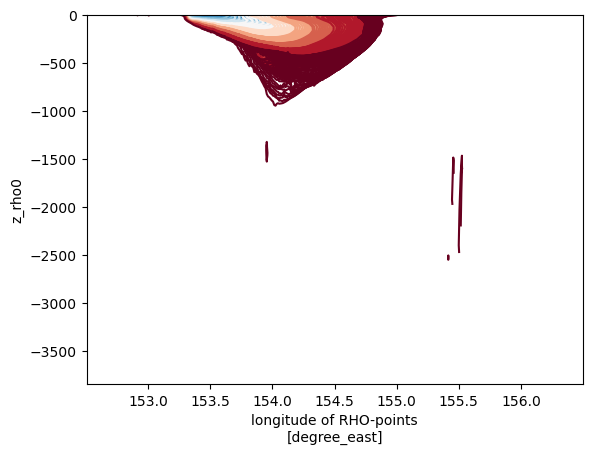

In [9]:
#get lons and lats for eac
#Find area of polygon
def PolyArea(x,y,eta_ind):
    dx= x*np.asarray((111132.954 * np.cos((math.pi/180*ds.lat_rho.isel(eta_rho=eta_ind)[1].values))))
    return 0.5*np.abs(np.dot(dx,np.roll(y,1))-np.dot(y,np.roll(dx,1)))*1e-6


eac_contour=pd.DataFrame(columns=['eta_rho','lon','centre_depth','max_depth','area'])

for eta_ind in range(5,595,5):
    
    
    cs=xr.plot.contour(ds.v_northward.isel(eta_rho=eta_ind,xi_rho=slice(100,500)).mean(dim="ocean_time"),x="lon_rho",y="z_rho0",levels=np.arange(-0.6,-0.05,0.05))

    coords=cs.allsegs[0][0]
    
    x,y=Polygon(coords).exterior.xy

    row_to_append=pd.DataFrame([{'eta_rho':eta_ind,'lon': pd.to_numeric(Polygon(coords).centroid.xy[0]),
                                 'centre_depth':pd.to_numeric(Polygon(coords).centroid.xy[1]),'max_depth':min(y),'area':PolyArea(x,y,eta_ind)}])
    eac_contour=pd.concat([eac_contour,row_to_append])

eac_contour


In [10]:
lats=ds.lat_rho[:,1].to_dataframe().iloc[:,[0]]
data=eac_contour.set_index(eac_contour.eta_rho).merge(lats,how='inner',right_index=True,left_index=True)
data['lon']=data['lon'].astype(str).str[1:-1].astype(float)
data


,eta_rho,lon,centre_depth,max_depth,area,lat_rho
eta_rho,,,,,,
5,5,153.901819,[-93.6072633688981],-217.588136,6.111479,-29.945
10,10,153.899328,[-92.76191176745603],-213.227977,6.140133,-29.895
15,15,153.905925,[-92.68432546788878],-219.559104,6.054983,-29.845
20,20,153.912025,[-90.94735576679038],-214.908765,5.858343,-29.795
25,25,153.921017,[-89.5152465218353],-211.965967,5.695247,-29.745
...,...,...,...,...,...,...
525,525,153.541790,[-12.317529123867818],-28.689510,0.562060,-24.745
530,530,153.520124,[-11.673022728260218],-26.424771,0.502524,-24.695
535,535,153.495557,[-10.172286808944833],-23.285038,0.406340,-24.645


In [11]:
lons=ds.lon_rho[1,:].to_dataframe().iloc[:,[1]]
data=data.sort_values(by='lon')
data

,eta_rho,lon,centre_depth,max_depth,area,lat_rho
eta_rho,,,,,,
545,545,153.438674,[-3.8866532169264008],-8.445479,0.100839,-24.545
540,540,153.468698,[-7.5030682915401234],-17.466530,0.263381,-24.595
535,535,153.495557,[-10.172286808944833],-23.285038,0.406340,-24.645
530,530,153.520124,[-11.673022728260218],-26.424771,0.502524,-24.695
525,525,153.541790,[-12.317529123867818],-28.689510,0.562060,-24.745
...,...,...,...,...,...,...
170,170,153.998365,[-75.36264509503907],-179.865503,3.229986,-28.295
180,180,153.999526,[-78.67743583780828],-196.171596,3.625588,-28.195
190,190,153.999951,[-81.89176152136046],-195.661853,3.873380,-28.095


In [12]:
lons=lons.reset_index()
data=pd.merge_asof(data,lons,left_on='lon',right_on='lon_rho')
coords=data[['eta_rho','xi_rho']]
coords

,eta_rho,xi_rho
0,545,193
1,540,196
2,535,199
3,530,201
4,525,203
...,...,...
104,170,249
105,180,249
106,190,249
107,185,249


In [13]:
# Interpolate data along the line
interpolated_data = pd.DataFrame(columns=['eta_rho','xi_rho','W_ek'])
mean_ek=ds.W_ek.mean(dim='ocean_time')
for xi, eta in zip(coords.xi_rho, coords.eta_rho):
    # Interpolate data at each point along the line using bilinear interpolation
    ek=mean_ek.interp(eta_rho=eta, xi_rho=xi)
    row_to_append=pd.DataFrame([{'eta_rho':ek.eta_rho.values.astype(int),'xi_rho': ek.xi_rho.values.astype(int), 'W_ek':ek.values.astype(float)}])
    interpolated_data=pd.concat([interpolated_data,row_to_append])

interpolated_data


,eta_rho,xi_rho,W_ek
0,545,193,0.00983176526458074
0,540,196,0.010562902143994463
0,535,199,0.009636847754455443
0,530,201,0.009172150529146014
0,525,203,0.008914627558370209
...,...,...,...
0,170,249,-0.0005476038517893117
0,180,249,-0.0008429727097580288
0,190,249,-0.001360452158782716
0,185,249,-0.0011982226243064937


In [14]:
interpolated_data['eta_rho']=interpolated_data.eta_rho.astype(int)
data=data.merge(interpolated_data,how='inner',left_on='eta_rho',right_on='eta_rho')

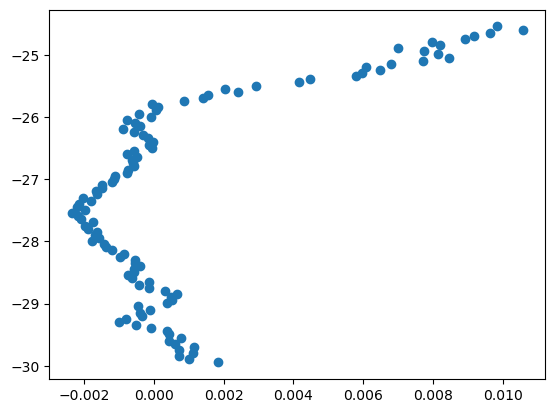

In [15]:
plt.scatter(data.W_ek,data.lat_rho)

<Figure size 640x480 with 0 Axes>

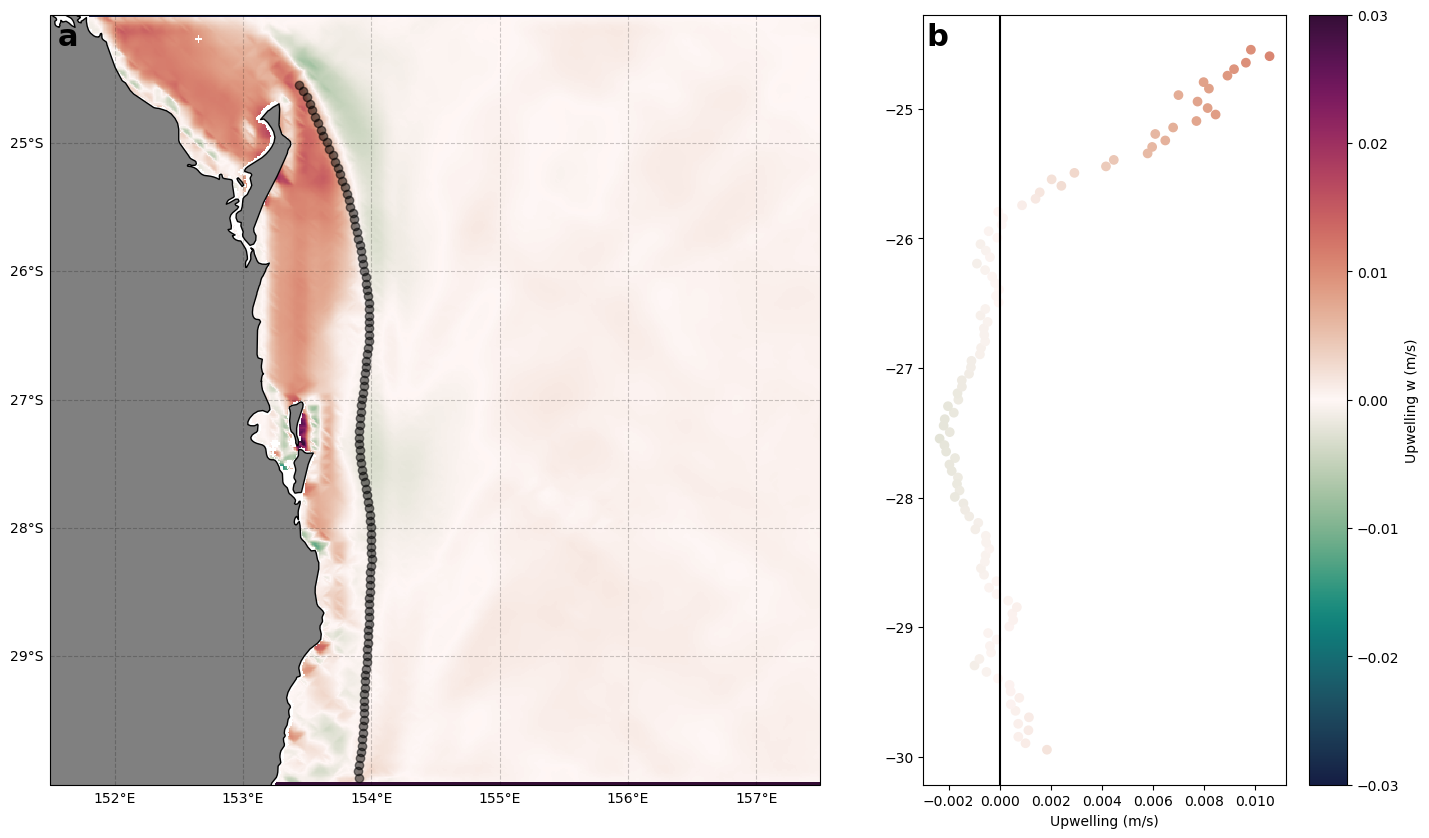

In [40]:
gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05,width_ratios=[2, 1])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[18,10])
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([151.5, 157.5, -30, -24])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
# im = (((ds.W_ek**2).mean(dim='ocean_time'))**0.5).plot(x='lon_rho',y='lat_rho',cmap='cmo.curl', add_colorbar=False,vmin=-.1,vmax=0.1)     
#im = (((ds.W_ek**1).mean(dim='ocean_time'))**1).plot(x='lon_rho',y='lat_rho',cmap='cmo.curl', add_colorbar=False,vmin=-.03,vmax=0.03)     
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho, (((ds.W_ek**1).mean(dim='ocean_time'))**1),vmin=-.03,vmax=0.03,cmap='cmo.curl')
#co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.25)     
#ax.clabel(co, co.levels, inline=True, fontsize=10)
plt.scatter(data.lon,data.lat_rho,c='black',alpha=0.5)

gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_title('') 

ax = fig.add_subplot(gs[0,1])
plt.scatter(data.W_ek,data.lat_rho,c=data.W_ek,cmap='cmo.curl',vmin=-0.03,vmax=0.03)
plt.axvline(x=0,c="black")
plt.xlabel("Upwelling (m/s)")
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
cbar=plt.colorbar()
cbar.set_label('Upwelling w (m/s)')

In [65]:
data['ek']=data.W_ek.astype(float)
data

,eta_rho,lon,centre_depth,max_depth,area,lat_rho,xi_rho_x,lon_rho,xi_rho_y,W_ek,ek
0,590,153.761967,[-104.41853782469066],-266.297334,16.050668,-24.095,225,153.755,225,-0.0011433101674401301,-0.001143
1,585,153.769623,[-107.37796337249584],-275.329897,17.039167,-24.145,226,153.765,226,-0.0011694460632550713,-0.001169
2,580,153.786572,[-110.34167971704738],-277.919667,17.644719,-24.195,228,153.785,228,-0.001335176993333343,-0.001335
3,575,153.803299,[-113.87642161875921],-286.373544,18.284049,-24.245,229,153.795,229,-0.0013102878771936656,-0.001310
4,570,153.822942,[-117.27778642901829],-291.355988,18.804591,-24.295,231,153.815,231,-0.0012235830401527666,-0.001224
...,...,...,...,...,...,...,...,...,...,...,...
112,130,154.231515,[-185.14034440084188],-443.285538,28.755605,-28.695,272,154.225,272,0.0004057590005295981,0.000406
113,125,154.231615,[-184.91315298212567],-442.590313,28.411087,-28.745,272,154.225,272,0.0005287474852514899,0.000529
114,150,154.231890,[-185.68556170993457],-450.236630,28.866588,-28.495,272,154.225,272,3.765461068976615e-05,0.000038
115,135,154.232021,[-185.50340807887127],-446.488369,28.993951,-28.645,272,154.225,272,0.0003571602540788466,0.000357


In [71]:
datac=data[(data['lat_rho']< -26) & (data['lat_rho']> -29)]
print(datac['max_depth'].corr(datac['ek']))
print(datac['area'].corr(datac['ek']))

0.36540631654778705
-0.0972016058766099


Text(0.01, 0.99, 'b')

<Figure size 640x480 with 0 Axes>

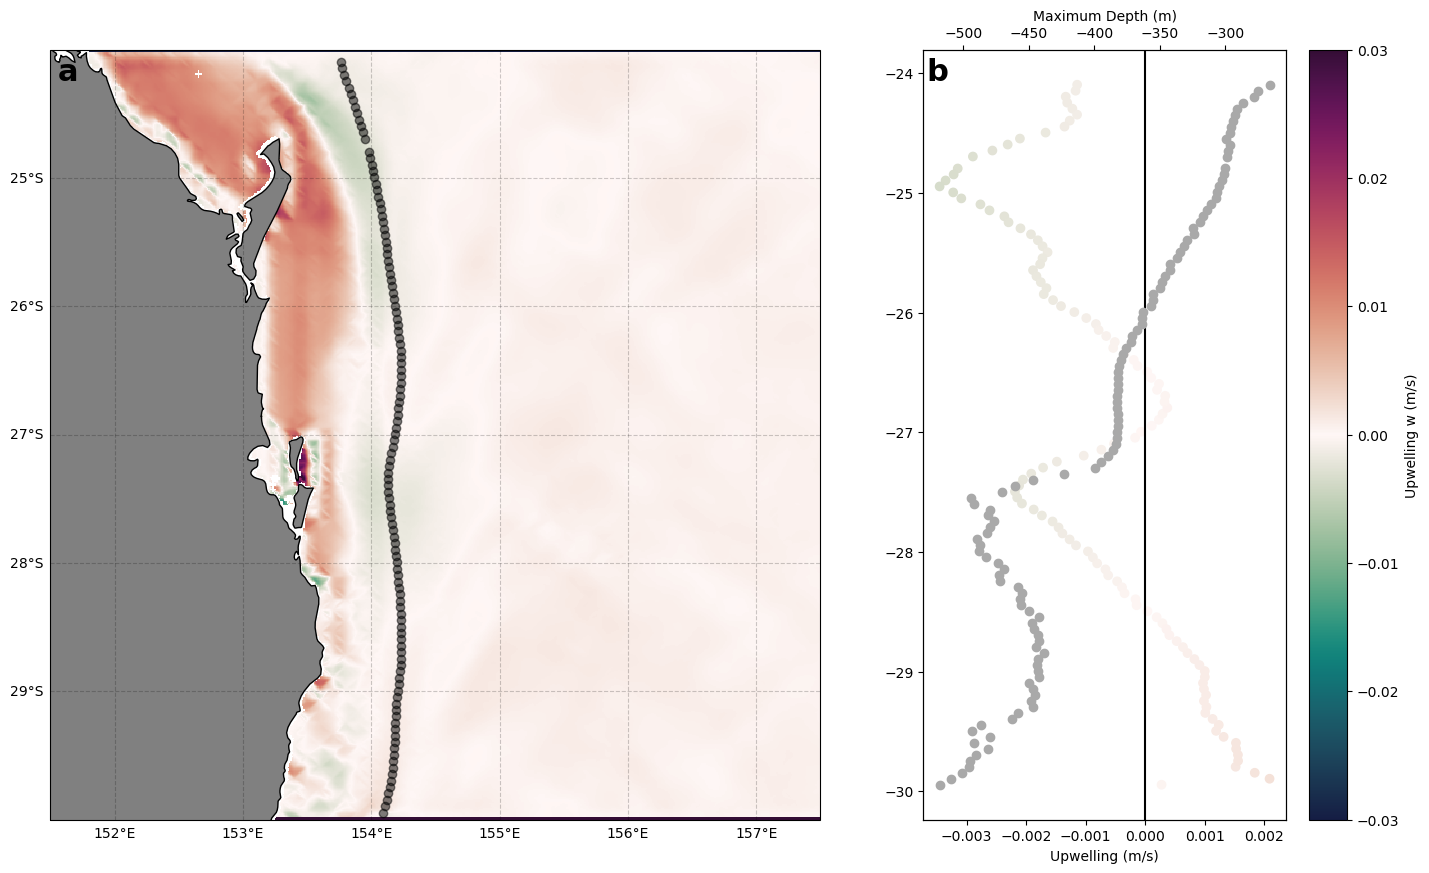

In [67]:
#plot together
gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05,width_ratios=[2, 1])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[18,10])
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([151.5, 157.5, -30, -24])
Coast = cfeature.NaturalEarthFeature(category='physical',scale='10m',facecolor='none', name='coastline')
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
# im = (((ds.W_ek**2).mean(dim='ocean_time'))**0.5).plot(x='lon_rho',y='lat_rho',cmap='cmo.curl', add_colorbar=False,vmin=-.1,vmax=0.1)     
#im = (((ds.W_ek**1).mean(dim='ocean_time'))**1).plot(x='lon_rho',y='lat_rho',cmap='cmo.curl', add_colorbar=False,vmin=-.03,vmax=0.03)     
im=ax.pcolormesh(ds.lon_rho,ds.lat_rho, (((ds.W_ek**1).mean(dim='ocean_time'))**1),vmin=-.03,vmax=0.03,cmap='cmo.curl')
#co = ds.h.plot.contour(x='lon_rho',y='lat_rho',colors='k',linewidths=0.25)     
#ax.clabel(co, co.levels, inline=True, fontsize=10)
plt.scatter(data.lon,data.lat_rho,c='black',alpha=0.5)

gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')

gl.right_labels = False
gl.top_labels = False
ax.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
ax.set_title('') 

ax = fig.add_subplot(gs[0,1])
plt.scatter(data.W_ek,data.lat_rho,c=data.W_ek,cmap='cmo.curl',vmin=-0.03,vmax=0.03)
plt.axvline(x=0,c="black")
plt.xlabel("Upwelling (m/s)")
cbar=plt.colorbar()
cbar.set_label('Upwelling w (m/s)')
ax2 = ax.twiny()
plt.scatter(data.max_depth,data.lat_rho,color='darkgrey')
plt.xlabel("Maximum Depth (m)")
ax.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')


Now for temporal

In [9]:
ds.ocean_time

<xarray.DataArray 'ocean_time' (ocean_time: 73)>
array(['2025-12-30T00:00:00.000000000', '2026-01-04T00:00:00.000000000',
       '2026-01-09T00:00:00.000000000', '2026-01-14T00:00:00.000000000',
       '2026-01-19T00:00:00.000000000', '2026-01-24T00:00:00.000000000',
       '2026-01-29T00:00:00.000000000', '2026-02-03T00:00:00.000000000',
       '2026-02-08T00:00:00.000000000', '2026-02-13T00:00:00.000000000',
       '2026-02-18T00:00:00.000000000', '2026-02-23T00:00:00.000000000',
       '2026-02-28T00:00:00.000000000', '2026-03-05T00:00:00.000000000',
       '2026-03-10T00:00:00.000000000', '2026-03-15T00:00:00.000000000',
       '2026-03-20T00:00:00.000000000', '2026-03-25T00:00:00.000000000',
       '2026-03-30T00:00:00.000000000', '2026-04-04T00:00:00.000000000',
       '2026-04-09T00:00:00.000000000', '2026-04-14T00:00:00.000000000',
       '2026-04-19T00:00:00.000000000', '2026-04-24T00:00:00.000000000',
       '2026-04-29T00:00:00.000000000', '2026-05-04T00:00:00.000000000',
       '2026-05-09T00:00:00.000000000', '2026-05-14T00:00:00.000000000',
       '2026-05-19T00:00:00.000000000', '2026-05-24T00:00:00.000000000',
       '2026-05-29T00:00:00.000000000', '2026-06-03T00:00:00.000000000',
       '2026-06-08T00:00:00.000000000', '2026-06-13T00:00:00.000000000',
       '2026-06-18T00:00:00.000000000', '2026-06-23T00:00:00.000000000',
       '2026-06-28T00:00:00.000000000', '2026-07-03T00:00:00.000000000',
       '2026-07-08T00:00:00.000000000', '2026-07-13T00:00:00.000000000',
       '2026-07-18T00:00:00.000000000', '2026-07-23T00:00:00.000000000',
       '2026-07-28T00:00:00.000000000', '2026-08-02T00:00:00.000000000',
       '2026-08-07T00:00:00.000000000', '2026-08-12T00:00:00.000000000',
       '2026-08-17T00:00:00.000000000', '2026-08-22T00:00:00.000000000',
       '2026-08-27T00:00:00.000000000', '2026-09-01T00:00:00.000000000',
       '2026-09-06T00:00:00.000000000', '2026-09-11T00:00:00.000000000',
       '2026-09-16T00:00:00.000000000', '2026-09-21T00:00:00.000000000',
       '2026-09-26T00:00:00.000000000', '2026-10-01T00:00:00.000000000',
       '2026-10-06T00:00:00.000000000', '2026-10-11T00:00:00.000000000',
       '2026-10-16T00:00:00.000000000', '2026-10-21T00:00:00.000000000',
       '2026-10-26T00:00:00.000000000', '2026-10-31T00:00:00.000000000',
       '2026-11-05T00:00:00.000000000', '2026-11-10T00:00:00.000000000',
       '2026-11-15T00:00:00.000000000', '2026-11-20T00:00:00.000000000',
       '2026-11-25T00:00:00.000000000', '2026-11-30T00:00:00.000000000',
       '2026-12-05T00:00:00.000000000', '2026-12-10T00:00:00.000000000',
       '2026-12-15T00:00:00.000000000', '2026-12-20T00:00:00.000000000',
       '2026-12-25T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2025-12-30 2026-01-04 ... 2026-12-25
Attributes:
    standard_name:  time
    long_name:      time since initialization
    bounds:         ocean_time_bnds
    axis:           T

In [31]:
data=pd.read_csv("/seq001/data/EAC_at29_06ms.csv")
data['lat_rho']=-28.995000
data['lon']=data['lon'].str[1:-1].astype(float)

dates = pd.to_datetime(ds['ocean_time'].values)  # Convert the numpy array of dates to Pandas datetime objects
modified_dates = [date.replace(year=2018) for date in dates]
modified_dates[0] = [date.replace(year=2017) for date in dates][0]
ds['ocean_time'] = modified_dates

time=ds.ocean_time.to_dataframe()
time['time_index']=np.arange(0,73)

data=data.merge(time,how='inner',left_on='time_index',right_on='time_index')

data

,Unnamed: 0,time_index,lon,centre_depth,max_depth,area,lat_rho,ocean_time
0,0,0,154.172913,[-154.03838868],-374.151849,19.595903,-28.995,2017-12-30
1,0,1,154.077622,[-134.79467185],-336.846395,12.702578,-28.995,2018-01-04
2,0,2,154.015112,[-127.02135692],-295.453318,6.979044,-28.995,2018-01-09
3,0,3,154.193239,[-48.83145273],-121.047003,2.664022,-28.995,2018-01-14
4,0,4,154.388806,[-102.02097076],-252.020520,8.201354,-28.995,2018-01-19
...,...,...,...,...,...,...,...,...
57,0,68,154.117791,[-129.30420988],-301.500772,13.905717,-28.995,2018-12-05
58,0,69,154.122085,[-163.53399639],-377.422119,18.380044,-28.995,2018-12-10
59,0,70,154.190561,[-164.57470836],-412.902948,23.681327,-28.995,2018-12-15
60,0,71,154.177380,[-173.76163425],-422.062042,21.437687,-28.995,2018-12-20


In [32]:
lons=ds.lon_rho[1,:].to_dataframe().iloc[:,[1]]
data=data.sort_values(by='lon')
lons=lons.reset_index()
data=pd.merge_asof(data,lons,left_on='lon',right_on='lon_rho')
data

,Unnamed: 0,time_index,lon,centre_depth,max_depth,area,lat_rho,ocean_time,xi_rho,lon_rho
0,0,49,153.652870,[-2.18433456],-4.722925,0.010307,-28.995,2018-09-01,214,153.645
1,0,20,153.669744,[-12.96688729],-30.609698,0.386482,-28.995,2018-04-09,216,153.665
2,0,48,153.747514,[-3.54306052],-8.383311,0.065050,-28.995,2018-08-27,224,153.745
3,0,47,153.839922,[-57.20229061],-140.035779,1.819180,-28.995,2018-08-22,233,153.835
4,0,8,153.856800,[-56.15765677],-131.370226,0.692443,-28.995,2018-02-08,235,153.855
...,...,...,...,...,...,...,...,...,...,...
57,0,24,154.880737,[-93.94725221],-228.864603,6.749562,-28.995,2018-04-29,337,154.875
58,0,23,154.942087,[-40.78944555],-102.539009,1.613340,-28.995,2018-04-24,343,154.935
59,0,41,155.095750,[-13.80076075],-31.787450,0.188567,-28.995,2018-07-23,359,155.095
60,0,40,155.229371,[-11.57891758],-26.840204,0.168055,-28.995,2018-07-18,372,155.225


In [33]:
# Interpolate data along the line
interpolated_data = pd.DataFrame(columns=['ocean_time','xi_rho','W_ek'])

for xi, time in zip(data.xi_rho, data.ocean_time):
    # Interpolate data at each point along the line using bilinear interpolation
    ek=ds.W_ek.interp(eta_rho=100, xi_rho=xi,ocean_time=time)
    row_to_append=pd.DataFrame([{'ocean_time':ek.ocean_time.values,'xi_rho': ek.xi_rho.values.astype(int) ,'W_ek':ek.values.astype(float)}])
    interpolated_data=pd.concat([interpolated_data,row_to_append])

interpolated_data

,ocean_time,xi_rho,W_ek
0,2018-09-01,214,0.007036930991683003
0,2018-04-09,216,-0.003874793172884722
0,2018-08-27,224,-0.0024626060210081527
0,2018-08-22,233,-0.004580223462403964
0,2018-02-08,235,0.00033276897468897254
...,...,...,...
0,2018-04-29,337,-0.00048678897486914563
0,2018-04-24,343,0.0017047961672101153
0,2018-07-23,359,-0.0008809728650005788
0,2018-07-18,372,0.000932840301180668


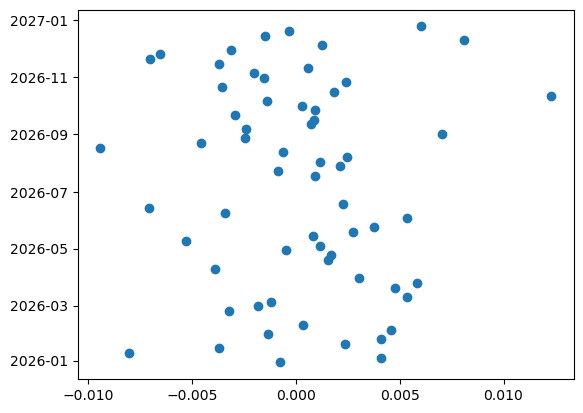

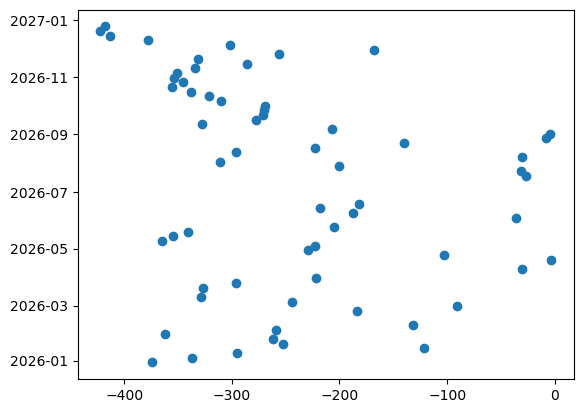

In [14]:
plt.scatter(data.W_ek,data.ocean_time)
plt.show()
plt.scatter(data.max_depth,data.ocean_time)

In [34]:
data=data.merge(interpolated_data,how='inner',left_on='ocean_time',right_on='ocean_time')
data

,Unnamed: 0,time_index,lon,centre_depth,max_depth,area,lat_rho,ocean_time,xi_rho_x,lon_rho,xi_rho_y,W_ek
0,0,49,153.652870,[-2.18433456],-4.722925,0.010307,-28.995,2018-09-01,214,153.645,214,0.007036930991683003
1,0,20,153.669744,[-12.96688729],-30.609698,0.386482,-28.995,2018-04-09,216,153.665,216,-0.003874793172884722
2,0,48,153.747514,[-3.54306052],-8.383311,0.065050,-28.995,2018-08-27,224,153.745,224,-0.0024626060210081527
3,0,47,153.839922,[-57.20229061],-140.035779,1.819180,-28.995,2018-08-22,233,153.835,233,-0.004580223462403964
4,0,8,153.856800,[-56.15765677],-131.370226,0.692443,-28.995,2018-02-08,235,153.855,235,0.00033276897468897254
...,...,...,...,...,...,...,...,...,...,...,...,...
57,0,24,154.880737,[-93.94725221],-228.864603,6.749562,-28.995,2018-04-29,337,154.875,337,-0.00048678897486914563
58,0,23,154.942087,[-40.78944555],-102.539009,1.613340,-28.995,2018-04-24,343,154.935,343,0.0017047961672101153
59,0,41,155.095750,[-13.80076075],-31.787450,0.188567,-28.995,2018-07-23,359,155.095,359,-0.0008809728650005788
60,0,40,155.229371,[-11.57891758],-26.840204,0.168055,-28.995,2018-07-18,372,155.225,372,0.000932840301180668


In [35]:
data['ek']=data.W_ek.astype(float)

print(data['max_depth'].corr(data['ek']))
print(data['area'].corr(data['ek']))

-0.057801557033524756
0.15440165313023577


In [131]:
data=data.sort_values(by="ocean_time")

In [30]:
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

crosscorr(data['max_depth'],data['ek'],lag=0)

-0.057801557033524756

Text(0.01, 0.99, 'c')

<Figure size 640x480 with 0 Axes>

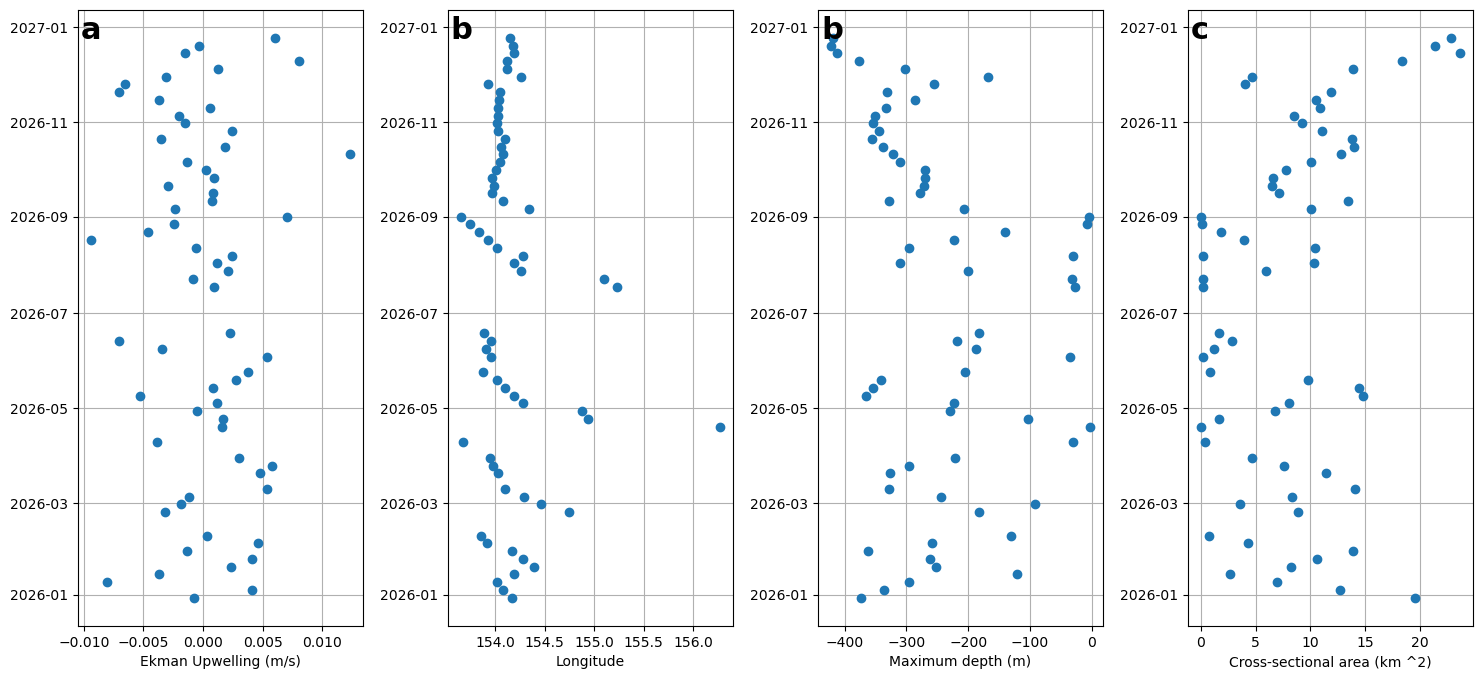

In [17]:
gs = gridspec.GridSpec(nrows=1,ncols=4,wspace=0.3, hspace=0.3)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[18,8])#what is this?
ax = None

ax = fig.add_subplot(gs[0,0])
ax.grid()
ax.set_axisbelow(True)
plt.scatter(data.ek,data.ocean_time)
#plt.xlim(47,49)
#plt.ylabel("Date")
plt.xlabel("Ekman Upwelling (m/s)")
plt.text(0.01, 0.99, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,1])
ax.grid()
ax.set_axisbelow(True)
plt.scatter(data.lon,data.ocean_time)
#plt.xlim(47,49)
#plt.ylabel("Date")
plt.xlabel("Longitude")
plt.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,2])
ax.grid()
ax.set_axisbelow(True)
plt.scatter(data.max_depth,data.ocean_time)
#plt.ylabel("Date")
plt.xlabel("Maximum depth (m)")
plt.text(0.01, 0.99, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')

ax = fig.add_subplot(gs[0,3])
ax.grid()
ax.set_axisbelow(True)
plt.scatter(data.area,data.ocean_time)

#plt.ylabel("Date")
plt.xlabel("Cross-sectional area (km ^2)")
plt.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')